In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Add, LayerNormalization

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Data directory
DATADIR = 'UCI HAR Dataset'

In [5]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    return np.transpose(signals_data, (1, 2, 0))

In [7]:
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [8]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [10]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [11]:
X_train, X_test, Y_train, Y_test = load_data()

In [12]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [13]:
X_train.shape

(7352, 128, 9)

In [14]:
# TCN Layer
def TCN(input_layer, filters, kernel_size=3, dilation_rate=1, dropout_rate=0.2):
    # 1st causal dilated conv
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(input_layer)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # 2nd causal dilated conv
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Match dimensions for residual connection
    if input_layer.shape[-1] != filters:
        residual = Conv1D(filters, 1, padding='same')(input_layer)
    else:
        residual = input_layer

    # Residual connection + normalization
    out = Add()([x, residual])
    out = LayerNormalization()(out)
    return out


In [15]:
class SelfAttention(Layer):
    def __init__(self, units, name=None, trainable=True, dtype=None):
        super(SelfAttention, self).__init__(name=name, trainable=trainable, dtype=dtype)  # Menambahkan 'dtype'
        self.units = units
        self.query_dense = Dense(units)
        self.key_dense = Dense(units)
        self.value_dense = Dense(units)

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.units, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output

    def get_config(self):
        config = super(SelfAttention, self).get_config()
        config.update({
            "units": self.units
        })
        return config

In [16]:
input_layer = Input(shape=(timesteps, input_dim))
x = input_layer

# Stacked dilated TCN blocks
for d in [1, 2, 4, 8]:  # Bisa ditambahin lebih dalam kalau mau
    x = TCN(x, filters=64, kernel_size=3, dilation_rate=d, dropout_rate=0.2)

# Self-Attention
attention_output = SelfAttention(units=64)(x)

# Global pooling + output
x = GlobalAveragePooling1D()(attention_output)
x = Dropout(0.5)(x)
output_layer = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 64)      1792        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 128, 64)      0           ['activation[0][0]']             
                                                                                              

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
history = model.fit(X_train, Y_train, batch_size=16, epochs=30, validation_data=(X_test, Y_test), callbacks=[early_stopping])


Epoch 1/30
460/460 [==============================] - 54s 99ms/step - loss: 0.2874 - accuracy: 0.8916 - val_loss: 0.3731 - val_accuracy: 0.8955
Epoch 2/30
460/460 [==============================] - 29s 63ms/step - loss: 0.1453 - accuracy: 0.9416 - val_loss: 0.3823 - val_accuracy: 0.9152
Epoch 3/30
460/460 [==============================] - 29s 64ms/step - loss: 0.1296 - accuracy: 0.9502 - val_loss: 0.3665 - val_accuracy: 0.9053
Epoch 4/30
460/460 [==============================] - 36s 77ms/step - loss: 0.1245 - accuracy: 0.9475 - val_loss: 0.4872 - val_accuracy: 0.9284
Epoch 5/30
460/460 [==============================] - 30s 64ms/step - loss: 0.1142 - accuracy: 0.9512 - val_loss: 0.5395 - val_accuracy: 0.9108
Epoch 6/30
460/460 [==============================] - 38s 83ms/step - loss: 0.1188 - accuracy: 0.9502 - val_loss: 0.3828 - val_accuracy: 0.9369
Epoch 7/30
460/460 [==============================] - 38s 82ms/step - loss: 0.1129 - accuracy: 0.9567 - val_loss: 0.3440 - val_accuracy:

93/93 [==============================] - 3s 29ms/step - loss: 0.3440 - accuracy: 0.9284

Test Loss: 0.3439544439315796
Test Accuracy: 0.92840176820755
93/93 [==============================] - 4s 29ms/step

Accuracy:  0.9284
Precision: 0.9336
Recall:    0.9294
F1 Score:  0.9286

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.98      0.95      0.96       496
  WALKING_UPSTAIRS       0.99      0.99      0.99       471
WALKING_DOWNSTAIRS       0.94      1.00      0.97       420
           SITTING       0.90      0.72      0.80       491
          STANDING       0.79      0.93      0.85       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



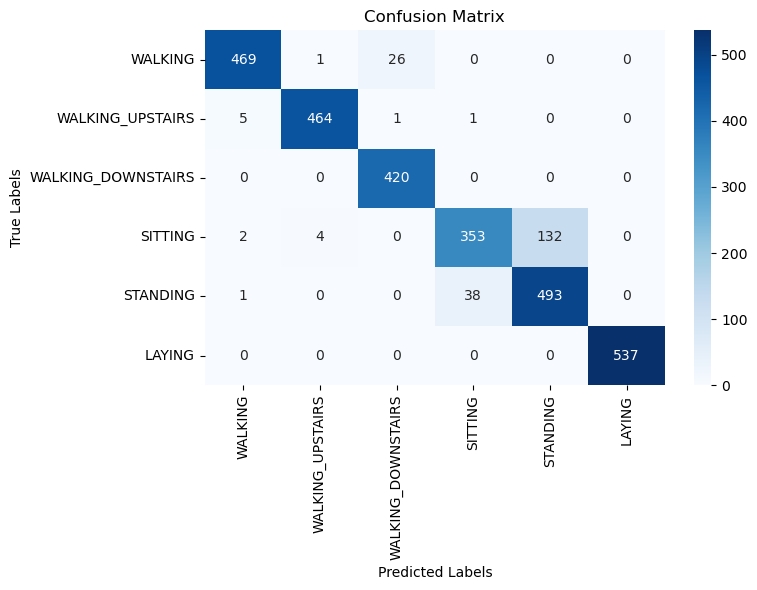

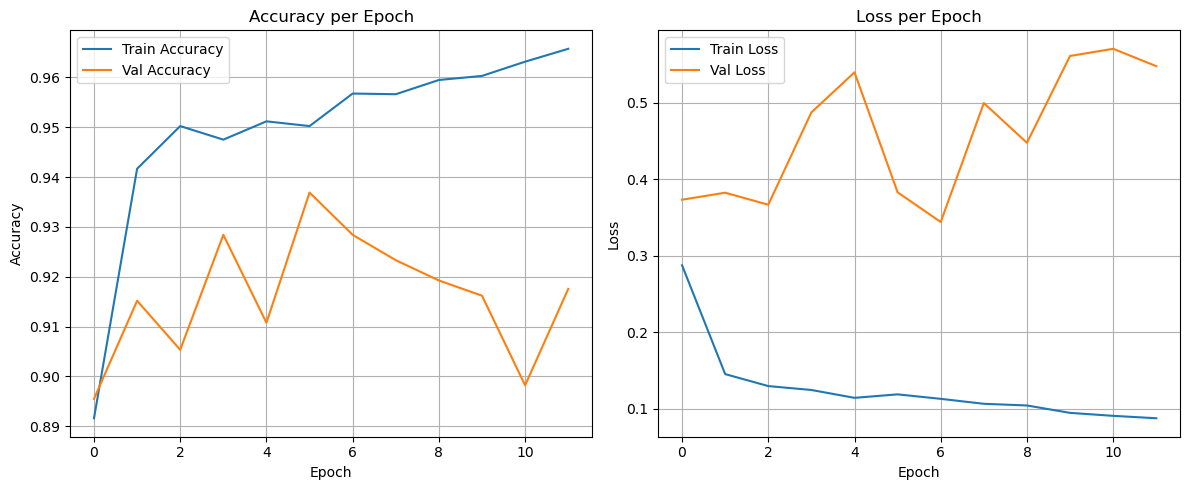

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Evaluate model
score = model.evaluate(X_test, Y_test)
print(f"\nTest Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
    "SITTING", "STANDING", "LAYING"
]))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"],
            yticklabels=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

# --- VISUALISASI TRAINING ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
model.save('skripshit_modelsidang.h5')

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='C:/Users/Muhammad Saffa/Documents/model_tcn_attention.png', show_shapes=True, show_layer_names=True, dpi=200)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
import os
from tensorflow.keras.utils import plot_model

print("Working dir:", os.getcwd())

try:
    path = 'D:/APALAH/tcn_attention_model.png'
    plot_model(model, to_file=path,
               show_shapes=True,
               show_layer_names=True,
               dpi=200)
    print(f"✅ Berhasil! Cek di: {path}")
except Exception as e:
    print("❌ Gagal generate gambar:", str(e))


Working dir: d:\APALAH\skripshit
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
✅ Berhasil! Cek di: D:/APALAH/tcn_attention_model.png


In [26]:
from PIL import Image

img = Image.new('RGB', (100, 100), color = (73, 109, 137))
img.save('C:/Users/Muhammad Saffa/Documents/test_image.png')


In [145]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('skripshit_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmpvm_2ef23\assets


INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmpvm_2ef23\assets
